In [1]:
from sys import path
path.append('..')
path.append('../../src/')

import os
import cv2
import numpy as np
import pickle as pkl
import matplotlib.pyplot as plt
import mlflow
import mlflow.keras
import random as rn
import tensorflow as tf
from os.path import basename, join, exists
from sys import stdout

from keras.models import Model, load_model
from keras.layers import Input, Dense, Dropout, BatchNormalization, Activation, Concatenate
from keras.layers import Conv2D, Conv2DTranspose, MaxPool2D, UpSampling2D, GlobalAvgPool2D
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.utils.data_utils import Sequence
from keras.utils.vis_utils import plot_model

import imgaug as ia
import imgaug.augmenters as iaa

from sklearn.model_selection import train_test_split
from skmultilearn.model_selection import iterative_train_test_split

from tensorflow.contrib.tensorboard.plugins import projector

from global_config import RANDOM_SEED, IMAGE_SIZE, FOLDER_IMAGES, FOLDER_MRKS
from local_config import FOLDER_MODELS, FILE_DATASET
from custom_losses import wing_loss
from custom_metrics import precision, recall, f1, specificity, fbeta
from custom_metrics import negative_predictive_value as npv 
from custom_metrics import matthews_correlation_coefficient as mcc
from custom_metrics import eye_localization_accuracy, eye_localization_fvc
from icao_dataset import ICAODataset
from data_structures import Point
from utils import plot, load

%matplotlib inline

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\tensorflow\python\util\nest.py:823: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  _pywrap_tensorflow.RegisterType("Mapping", _collections.Mapping)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\tensorflow\python\training\checkpointable\data_structures.py:312: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  class _ListWrapper(List, collections.MutableSequence,
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\tensorflow\python\training\checkpointable\util.py:448: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  class _ObjectIdentitySet(collections.MutableSet):
Using Te

In [2]:
PATH_TO_ROOT = '../../'

FOLDER_LOGS = join(PATH_TO_ROOT, 'logs')
FOLDER_MODELS = join(PATH_TO_ROOT, FOLDER_MODELS)
FILE_DATASET = join(PATH_TO_ROOT, FILE_DATASET)
FILE_BEST_MODEL = join(PATH_TO_ROOT, 'models/unsupervised_supervised/multilearner_2020_07_12-02_22_54.h5')

print(FOLDER_LOGS)
print(FOLDER_MODELS)
print(FILE_DATASET)
print(FILE_BEST_MODEL)

../../logs
../../models/unsupervised_supervised/
../../data/celebfaces/dataset.pkl
../../models/unsupervised_supervised/multilearner_2020_07_12-02_22_54.h5


In [3]:
TEST_SIZE = 0.1
MLFLOW_EXPERIMENT_NAME = 'Unsupervised + Supervised'

In [4]:
def timestamp_model_name(prefix='model_', suffix='', format='%Y_%m_%d-%H_%M_%S', ext='.h5'):
    from datetime import datetime
    timestamp = datetime.now().strftime(format)
    return f'{prefix}{timestamp}{suffix}{ext}'


def set_random_seeds():
    os.environ['PYTHONHASHSEED'] = str(RANDOM_SEED)
    rn.seed(RANDOM_SEED)
    np.random.seed(RANDOM_SEED)
    tf.set_random_seed(RANDOM_SEED)

# Data Loading 

In [5]:
if exists(FILE_DATASET):
    print("Dataset found. Loading...")
    dataset = pkl.load(open(FILE_DATASET, "rb"))
else:
    print("Generating dataset...")
    dataset = ICAODataset()
    dataset.load(FOLDER_IMAGES, FOLDER_MRKS, output_size=(160, 160))
    pkl.dump(dataset, open(FILE_DATASET, "wb"))

Dataset found. Loading...


In [6]:
x = np.array(dataset.images)
mrks = np.array(dataset.mrks)
y_reqs = np.array([mrk_file.photo_reqs.values() for mrk_file in mrks])
y_eyes = np.array([mrk_file.right_eye.center().as_list() + mrk_file.left_eye.center().as_list() for mrk_file in mrks]).astype(np.float32)
# y_eyes = np.array(dataset.y_images)

print(x.shape, x.dtype)
print(y_reqs.shape, y_reqs.dtype)
print(y_eyes.shape, y_eyes.dtype)
print(len(mrks))

(15000, 160, 160, 3) uint8
(15000, 23) int32
(15000, 4) float32
15000


In [7]:
y_eyes.min(), y_eyes.max()

(53.0, 107.0)

In [8]:
x = x / 255
y_eyes /= x.shape[1]

In [9]:
x.min(), x.max()

(0.0, 1.0)

In [10]:
y_eyes.min(), y_eyes.max()

(0.33125, 0.66875)

#### divide train and test

In [11]:
train_idx, val_idx = train_test_split(np.arange(x.shape[0]), test_size=TEST_SIZE, random_state=42)
x_train = x[train_idx]
x_val = x[val_idx]

y_train_reqs = y_reqs[train_idx]
y_val_reqs = y_reqs[val_idx]

y_train_eyes = y_eyes[train_idx]
y_val_eyes = y_eyes[val_idx]

print(x_train.shape, y_train_reqs.shape, y_train_eyes.shape)
print(x_val.shape, y_val_reqs.shape, y_val_eyes.shape)

(13500, 160, 160, 3) (13500, 23) (13500, 4)
(1500, 160, 160, 3) (1500, 23) (1500, 4)


In [12]:
train_mrks = mrks[train_idx]
val_mrks = mrks[val_idx]

# Data Augmentation 

In [ ]:
class ImageLandmarkGenerator(Sequence):
    """ImageDataGenerator + ImgAug"""
    def __init__(self, x, y_reqs, y_eyes, batch_size=32, shuffle=True, **affine_kwargs):
        self.x = x
        self.y_reqs = y_reqs
        self.y_eyes = y_eyes
        self.batch_size = min(batch_size, x.shape[0])
        self.shuffle = shuffle
        self.aug = iaa.Affine(**affine_kwargs)
        self.indexes = np.arange(self.x.shape[0])
        if shuffle:# Data Augmentation 
            np.random.shuffle(self.indexes)
        
    def __len__(self):
        return self.x.shape[0] // self.batch_size
    
    def on_epoch_end(self):
        self.indexes = np.arange(self.x.shape[0])
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __getitem__(self, idx):
        indexes = self.indexes[idx * self.batch_size : (idx + 1) * self.batch_size]
        images = self.x[indexes]
        reqs = self.y_reqs[indexes]
        landmarks = self.y_eyes[indexes]
        shape = self.x.shape[1:]
        
        keypoints = [ia.KeypointsOnImage.from_xy_array(landmark.reshape(-1, 2), shape=shape) for landmark in landmarks]
        images_aug, keypoints_aug = self.aug(images=images, keypoints=keypoints)
        landmarks_aug = np.array([kp.to_xy_array().flatten() for kp in keypoints_aug])

        return images_aug / 255, [images_aug / 255, reqs, landmarks_aug / x.shape[1]]

In [ ]:
affine_params = dict(
    translate_percent=[-0.2, 0.2],
    rotate=[-30, 30],
    scale=[0.8, 1.2],
    order=0,
)

gen = ImageLandmarkGenerator(x_train, y_train_reqs, y_train_eyes, batch_size=7, **affine_params)
_, (images, _, landmarks) = gen.__getitem__(0)
print(images.shape, landmarks.shape)

draw_list = []
for im, landmark in zip(images, landmarks):
    kp = ia.KeypointsOnImage.from_xy_array((landmark * x_train.shape[1]).reshape(-1, 2), shape=im.shape)
    draw_list.append(kp.draw_on_image((im * 255).astype(np.uint8)[:, :, ::-1], size=5))

ia.imshow(np.hstack(draw_list))

# Model Training 

In [13]:
custom_objects = {
    "precision": precision,
    "recall": recall,
    "f1": f1,
    "specificity": specificity,
    "fbeta": fbeta,
    "negative_predictive_value": npv,
    "matthews_correlation_coefficient": mcc
}

best_model = load_model(FILE_BEST_MODEL, custom_objects=custom_objects)

for layer in best_model.layers:
    layer.trainable = False

Instructions for updating:
Colocations handled automatically by placer.


C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)


Instructions for updating:
Use tf.cast instead.


In [14]:
def dense_layer(idx, prev_input, units, dropout=True, rate=0.5, activation='relu'):
    dense_name = f"dense_{idx}"
    drop_name = f"dropout_{idx}"
    
    if dropout:
        prev_input = Dropout(rate, name=drop_name)(prev_input)
    out = Dense(units, activation=activation, name=dense_name)(prev_input)
    return out

In [17]:
mlflow.set_experiment(MLFLOW_EXPERIMENT_NAME)
mlflow.log_param("test_size", TEST_SIZE)
mlflow.log_param("seed", RANDOM_SEED)
mlflow.keras.autolog()

set_random_seeds()
N_EYES = y_train_eyes.shape[1]

avg_pool = best_model.get_layer("global_average_pooling2d_1").output

dense_3 = dense_layer(3, avg_pool, 64)
dense_4 = dense_layer(4, dense_3, 64)
regress = Dense(units=N_EYES, activation='sigmoid', name='output_eyes')(dense_4)

model = Model(
    inputs=best_model.inputs,
    outputs=[
        best_model.get_layer("decoded").output,
        best_model.get_layer("outputs").output,
        regress
    ],
)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 160, 160, 3)  0                                            
__________________________________________________________________________________________________
conv_1 (Conv2D)                 (None, 160, 160, 32) 896         input[0][0]                      
__________________________________________________________________________________________________
bn_1 (BatchNormalization)       (None, 160, 160, 32) 128         conv_1[0][0]                     
__________________________________________________________________________________________________
relu_1 (Activation)             (None, 160, 160, 32) 0           bn_1[0][0]                       
____________________________________________________________________________________________

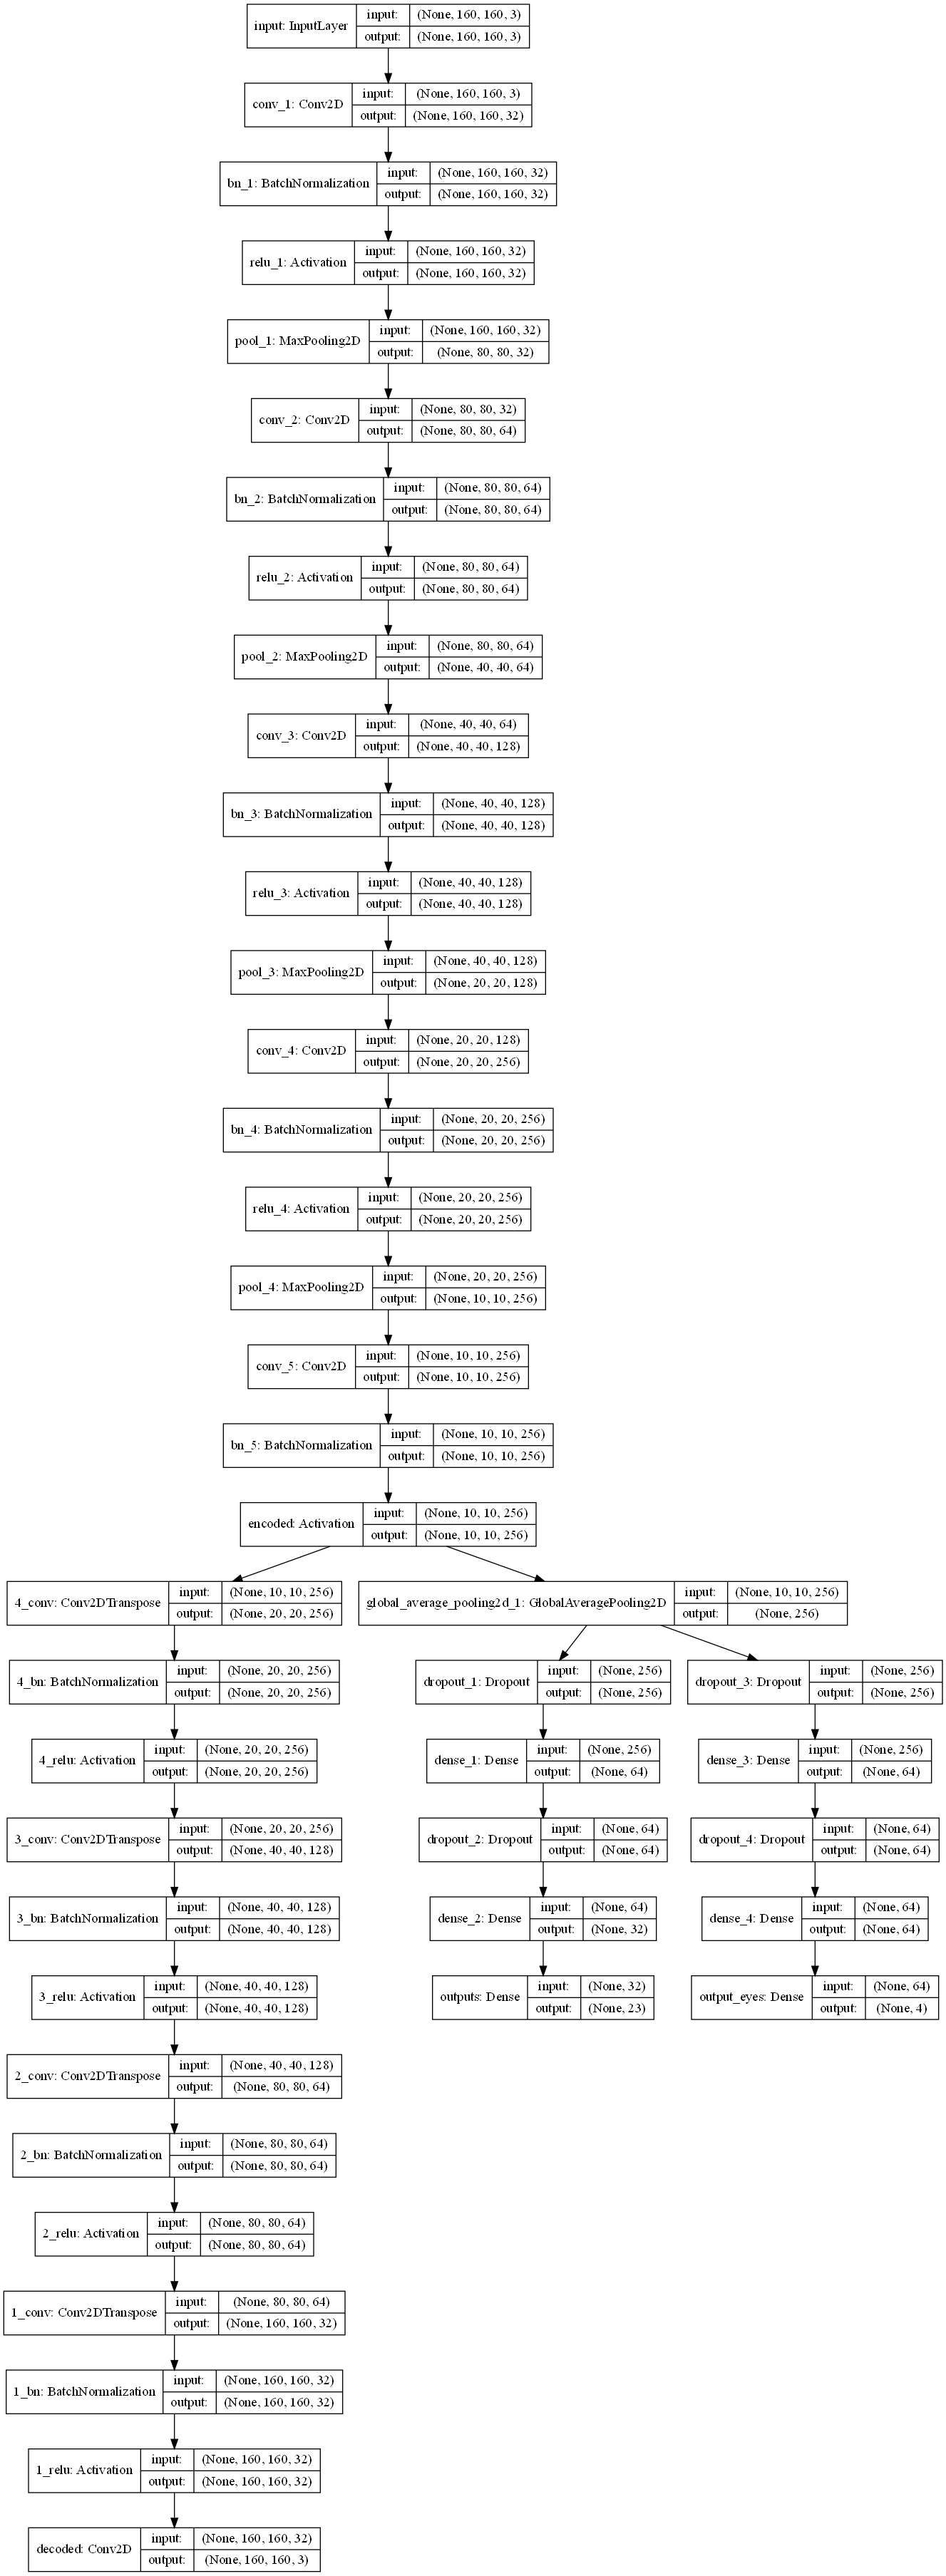

In [18]:
plot_model(model, show_shapes=True)

In [19]:
DECODED_LOSS_WEIGHT = 0.0
REQS_LOSS_WEIGHT = 0.0
EYES_LOSS_WEIGHT = 1.0

mlflow.log_param("decoded loss weight", DECODED_LOSS_WEIGHT)
mlflow.log_param("reqs loss weight", REQS_LOSS_WEIGHT)
mlflow.log_param("eyes loss weight", EYES_LOSS_WEIGHT)

losses = {
    "decoded": "mean_squared_error",
    "outputs": "binary_crossentropy",
    "output_eyes": eye_localization_fvc
}

loss_weights = {
    "decoded": DECODED_LOSS_WEIGHT,
    "outputs": REQS_LOSS_WEIGHT,
    "output_eyes": EYES_LOSS_WEIGHT,
}

metrics = {
    "outputs": ["accuracy", precision, recall, f1, fbeta, specificity, npv, mcc],
    "output_eyes": ["mae", "mse", eye_localization_accuracy]
}
METRIC_TO_MONITOR = "val_output_eyes_eye_localization_accuracy"
METRIC_MODE = "max"

model.compile(optimizer='adam', loss=losses, loss_weights=loss_weights, metrics=metrics)

FILE_MODEL = FOLDER_MODELS + timestamp_model_name(prefix="multilearner_")
list_callbacks = [
    ModelCheckpoint(FILE_MODEL, monitor=METRIC_TO_MONITOR, mode=METRIC_MODE, verbose=1, save_best_only=True), 
    EarlyStopping(monitor=METRIC_TO_MONITOR, mode=METRIC_MODE, patience=50, verbose=1, restore_best_weights=True)
]

Train on 13500 samples, validate on 1500 samples
Epoch 1/500
13500/13500 [==============================] - 90s 7ms/step - loss: 0.1227 - decoded_loss: 0.0092 - outputs_loss: 7.9099 - output_eyes_loss: 0.1227 - outputs_accuracy: 0.0000e+00 - outputs_precision: 0.0000e+00 - outputs_recall: 0.0000e+00 - outputs_f1: 0.0000e+00 - outputs_fbeta: 0.0000e+00 - outputs_specificity: 0.2266 - outputs_negative_predictive_value: 1.0000 - outputs_matthews_correlation_coefficient: 0.0000e+00 - output_eyes_mae: 0.0147 - output_eyes_mse: 5.6390e-04 - output_eyes_eye_localization_accuracy: 0.5913 - val_loss: 0.0535 - val_decoded_loss: 0.0074 - val_outputs_loss: 7.2068 - val_output_eyes_loss: 0.0535 - val_outputs_accuracy: 0.0000e+00 - val_outputs_precision: 0.0000e+00 - val_outputs_recall: 0.0000e+00 - val_outputs_f1: 0.0000e+00 - val_outputs_fbeta: 0.0000e+00 - val_outputs_specificity: 0.2568 - val_outputs_negative_predictive_value: 1.0000 - val_outputs_matthews_correlation_coefficient: 0.0000e+00 - v


Epoch 00007: val_output_eyes_eye_localization_accuracy did not improve from 0.93930
Epoch 8/500
13500/13500 [==============================] - 68s 5ms/step - loss: 0.0479 - decoded_loss: 0.0093 - outputs_loss: 7.8785 - output_eyes_loss: 0.0479 - outputs_accuracy: 0.0000e+00 - outputs_precision: 0.0000e+00 - outputs_recall: 0.0000e+00 - outputs_f1: 0.0000e+00 - outputs_fbeta: 0.0000e+00 - outputs_specificity: 0.2276 - outputs_negative_predictive_value: 1.0000 - outputs_matthews_correlation_coefficient: 0.0000e+00 - output_eyes_mae: 0.0062 - output_eyes_mse: 7.8017e-05 - output_eyes_eye_localization_accuracy: 0.9430 - val_loss: 0.0559 - val_decoded_loss: 0.0074 - val_outputs_loss: 7.2068 - val_output_eyes_loss: 0.0559 - val_outputs_accuracy: 0.0000e+00 - val_outputs_precision: 0.0000e+00 - val_outputs_recall: 0.0000e+00 - val_outputs_f1: 0.0000e+00 - val_outputs_fbeta: 0.0000e+00 - val_outputs_specificity: 0.2568 - val_outputs_negative_predictive_value: 1.0000 - val_outputs_matthews_cor

13500/13500 [==============================] - 75s 6ms/step - loss: 0.0473 - decoded_loss: 0.0093 - outputs_loss: 7.9277 - output_eyes_loss: 0.0473 - outputs_accuracy: 0.0000e+00 - outputs_precision: 0.0000e+00 - outputs_recall: 0.0000e+00 - outputs_f1: 0.0000e+00 - outputs_fbeta: 0.0000e+00 - outputs_specificity: 0.2261 - outputs_negative_predictive_value: 1.0000 - outputs_matthews_correlation_coefficient: 0.0000e+00 - output_eyes_mae: 0.0061 - output_eyes_mse: 7.6481e-05 - output_eyes_eye_localization_accuracy: 0.9436 - val_loss: 0.0513 - val_decoded_loss: 0.0074 - val_outputs_loss: 7.2068 - val_output_eyes_loss: 0.0513 - val_outputs_accuracy: 0.0000e+00 - val_outputs_precision: 0.0000e+00 - val_outputs_recall: 0.0000e+00 - val_outputs_f1: 0.0000e+00 - val_outputs_fbeta: 0.0000e+00 - val_outputs_specificity: 0.2568 - val_outputs_negative_predictive_value: 1.0000 - val_outputs_matthews_correlation_coefficient: 0.0000e+00 - val_output_eyes_mae: 0.0067 - val_output_eyes_mse: 9.2007e-05 

13500/13500 [==============================] - 68s 5ms/step - loss: 0.0469 - decoded_loss: 0.0093 - outputs_loss: 7.9049 - output_eyes_loss: 0.0469 - outputs_accuracy: 0.0000e+00 - outputs_precision: 0.0000e+00 - outputs_recall: 0.0000e+00 - outputs_f1: 0.0000e+00 - outputs_fbeta: 0.0000e+00 - outputs_specificity: 0.2270 - outputs_negative_predictive_value: 1.0000 - outputs_matthews_correlation_coefficient: 0.0000e+00 - output_eyes_mae: 0.0061 - output_eyes_mse: 7.5480e-05 - output_eyes_eye_localization_accuracy: 0.9472 - val_loss: 0.0466 - val_decoded_loss: 0.0074 - val_outputs_loss: 7.2068 - val_output_eyes_loss: 0.0466 - val_outputs_accuracy: 0.0000e+00 - val_outputs_precision: 0.0000e+00 - val_outputs_recall: 0.0000e+00 - val_outputs_f1: 0.0000e+00 - val_outputs_fbeta: 0.0000e+00 - val_outputs_specificity: 0.2568 - val_outputs_negative_predictive_value: 1.0000 - val_outputs_matthews_correlation_coefficient: 0.0000e+00 - val_output_eyes_mae: 0.0061 - val_output_eyes_mse: 7.8219e-05 

13500/13500 [==============================] - 67s 5ms/step - loss: 0.0463 - decoded_loss: 0.0093 - outputs_loss: 7.9235 - output_eyes_loss: 0.0463 - outputs_accuracy: 0.0000e+00 - outputs_precision: 0.0000e+00 - outputs_recall: 0.0000e+00 - outputs_f1: 0.0000e+00 - outputs_fbeta: 0.0000e+00 - outputs_specificity: 0.2267 - outputs_negative_predictive_value: 1.0000 - outputs_matthews_correlation_coefficient: 0.0000e+00 - output_eyes_mae: 0.0061 - output_eyes_mse: 7.3414e-05 - output_eyes_eye_localization_accuracy: 0.9470 - val_loss: 0.0542 - val_decoded_loss: 0.0074 - val_outputs_loss: 7.2068 - val_output_eyes_loss: 0.0542 - val_outputs_accuracy: 0.0000e+00 - val_outputs_precision: 0.0000e+00 - val_outputs_recall: 0.0000e+00 - val_outputs_f1: 0.0000e+00 - val_outputs_fbeta: 0.0000e+00 - val_outputs_specificity: 0.2568 - val_outputs_negative_predictive_value: 1.0000 - val_outputs_matthews_correlation_coefficient: 0.0000e+00 - val_output_eyes_mae: 0.0071 - val_output_eyes_mse: 1.0166e-04 

13500/13500 [==============================] - 66s 5ms/step - loss: 0.0466 - decoded_loss: 0.0093 - outputs_loss: 7.8984 - output_eyes_loss: 0.0465 - outputs_accuracy: 0.0000e+00 - outputs_precision: 0.0000e+00 - outputs_recall: 0.0000e+00 - outputs_f1: 0.0000e+00 - outputs_fbeta: 0.0000e+00 - outputs_specificity: 0.2264 - outputs_negative_predictive_value: 1.0000 - outputs_matthews_correlation_coefficient: 0.0000e+00 - output_eyes_mae: 0.0061 - output_eyes_mse: 7.4591e-05 - output_eyes_eye_localization_accuracy: 0.9473 - val_loss: 0.0496 - val_decoded_loss: 0.0074 - val_outputs_loss: 7.2068 - val_output_eyes_loss: 0.0496 - val_outputs_accuracy: 0.0000e+00 - val_outputs_precision: 0.0000e+00 - val_outputs_recall: 0.0000e+00 - val_outputs_f1: 0.0000e+00 - val_outputs_fbeta: 0.0000e+00 - val_outputs_specificity: 0.2568 - val_outputs_negative_predictive_value: 1.0000 - val_outputs_matthews_correlation_coefficient: 0.0000e+00 - val_output_eyes_mae: 0.0065 - val_output_eyes_mse: 8.7618e-05 

13500/13500 [==============================] - 65s 5ms/step - loss: 0.0465 - decoded_loss: 0.0093 - outputs_loss: 7.9019 - output_eyes_loss: 0.0465 - outputs_accuracy: 0.0000e+00 - outputs_precision: 0.0000e+00 - outputs_recall: 0.0000e+00 - outputs_f1: 0.0000e+00 - outputs_fbeta: 0.0000e+00 - outputs_specificity: 0.2267 - outputs_negative_predictive_value: 1.0000 - outputs_matthews_correlation_coefficient: 0.0000e+00 - output_eyes_mae: 0.0061 - output_eyes_mse: 7.4368e-05 - output_eyes_eye_localization_accuracy: 0.9492 - val_loss: 0.0485 - val_decoded_loss: 0.0074 - val_outputs_loss: 7.2068 - val_output_eyes_loss: 0.0485 - val_outputs_accuracy: 0.0000e+00 - val_outputs_precision: 0.0000e+00 - val_outputs_recall: 0.0000e+00 - val_outputs_f1: 0.0000e+00 - val_outputs_fbeta: 0.0000e+00 - val_outputs_specificity: 0.2568 - val_outputs_negative_predictive_value: 1.0000 - val_outputs_matthews_correlation_coefficient: 0.0000e+00 - val_output_eyes_mae: 0.0064 - val_output_eyes_mse: 8.4436e-05 

13500/13500 [==============================] - 65s 5ms/step - loss: 0.0460 - decoded_loss: 0.0093 - outputs_loss: 7.9202 - output_eyes_loss: 0.0460 - outputs_accuracy: 0.0000e+00 - outputs_precision: 0.0000e+00 - outputs_recall: 0.0000e+00 - outputs_f1: 0.0000e+00 - outputs_fbeta: 0.0000e+00 - outputs_specificity: 0.2262 - outputs_negative_predictive_value: 1.0000 - outputs_matthews_correlation_coefficient: 0.0000e+00 - output_eyes_mae: 0.0060 - output_eyes_mse: 7.3511e-05 - output_eyes_eye_localization_accuracy: 0.9472 - val_loss: 0.0476 - val_decoded_loss: 0.0074 - val_outputs_loss: 7.2068 - val_output_eyes_loss: 0.0476 - val_outputs_accuracy: 0.0000e+00 - val_outputs_precision: 0.0000e+00 - val_outputs_recall: 0.0000e+00 - val_outputs_f1: 0.0000e+00 - val_outputs_fbeta: 0.0000e+00 - val_outputs_specificity: 0.2568 - val_outputs_negative_predictive_value: 1.0000 - val_outputs_matthews_correlation_coefficient: 0.0000e+00 - val_output_eyes_mae: 0.0062 - val_output_eyes_mse: 8.0659e-05 

13500/13500 [==============================] - 65s 5ms/step - loss: 0.0461 - decoded_loss: 0.0093 - outputs_loss: 7.9227 - output_eyes_loss: 0.0461 - outputs_accuracy: 0.0000e+00 - outputs_precision: 0.0000e+00 - outputs_recall: 0.0000e+00 - outputs_f1: 0.0000e+00 - outputs_fbeta: 0.0000e+00 - outputs_specificity: 0.2265 - outputs_negative_predictive_value: 1.0000 - outputs_matthews_correlation_coefficient: 0.0000e+00 - output_eyes_mae: 0.0060 - output_eyes_mse: 7.3921e-05 - output_eyes_eye_localization_accuracy: 0.9489 - val_loss: 0.0472 - val_decoded_loss: 0.0074 - val_outputs_loss: 7.2068 - val_output_eyes_loss: 0.0472 - val_outputs_accuracy: 0.0000e+00 - val_outputs_precision: 0.0000e+00 - val_outputs_recall: 0.0000e+00 - val_outputs_f1: 0.0000e+00 - val_outputs_fbeta: 0.0000e+00 - val_outputs_specificity: 0.2568 - val_outputs_negative_predictive_value: 1.0000 - val_outputs_matthews_correlation_coefficient: 0.0000e+00 - val_output_eyes_mae: 0.0061 - val_output_eyes_mse: 8.0143e-05 

13500/13500 [==============================] - 65s 5ms/step - loss: 0.0461 - decoded_loss: 0.0093 - outputs_loss: 7.8927 - output_eyes_loss: 0.0461 - outputs_accuracy: 0.0000e+00 - outputs_precision: 0.0000e+00 - outputs_recall: 0.0000e+00 - outputs_f1: 0.0000e+00 - outputs_fbeta: 0.0000e+00 - outputs_specificity: 0.2266 - outputs_negative_predictive_value: 1.0000 - outputs_matthews_correlation_coefficient: 0.0000e+00 - output_eyes_mae: 0.0060 - output_eyes_mse: 7.3093e-05 - output_eyes_eye_localization_accuracy: 0.9490 - val_loss: 0.0484 - val_decoded_loss: 0.0074 - val_outputs_loss: 7.2068 - val_output_eyes_loss: 0.0484 - val_outputs_accuracy: 0.0000e+00 - val_outputs_precision: 0.0000e+00 - val_outputs_recall: 0.0000e+00 - val_outputs_f1: 0.0000e+00 - val_outputs_fbeta: 0.0000e+00 - val_outputs_specificity: 0.2568 - val_outputs_negative_predictive_value: 1.0000 - val_outputs_matthews_correlation_coefficient: 0.0000e+00 - val_output_eyes_mae: 0.0064 - val_output_eyes_mse: 8.4686e-05 

13500/13500 [==============================] - 65s 5ms/step - loss: 0.0457 - decoded_loss: 0.0093 - outputs_loss: 7.9089 - output_eyes_loss: 0.0457 - outputs_accuracy: 0.0000e+00 - outputs_precision: 0.0000e+00 - outputs_recall: 0.0000e+00 - outputs_f1: 0.0000e+00 - outputs_fbeta: 0.0000e+00 - outputs_specificity: 0.2268 - outputs_negative_predictive_value: 1.0000 - outputs_matthews_correlation_coefficient: 0.0000e+00 - output_eyes_mae: 0.0060 - output_eyes_mse: 7.2389e-05 - output_eyes_eye_localization_accuracy: 0.9485 - val_loss: 0.0473 - val_decoded_loss: 0.0074 - val_outputs_loss: 7.2068 - val_output_eyes_loss: 0.0472 - val_outputs_accuracy: 0.0000e+00 - val_outputs_precision: 0.0000e+00 - val_outputs_recall: 0.0000e+00 - val_outputs_f1: 0.0000e+00 - val_outputs_fbeta: 0.0000e+00 - val_outputs_specificity: 0.2568 - val_outputs_negative_predictive_value: 1.0000 - val_outputs_matthews_correlation_coefficient: 0.0000e+00 - val_output_eyes_mae: 0.0061 - val_output_eyes_mse: 7.9805e-05 

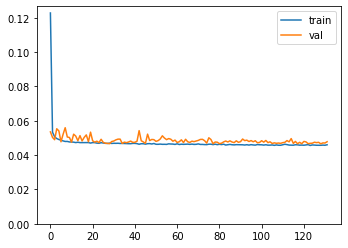

In [20]:
outputs_train = {
    "decoded": x_train,
    "outputs": y_train_reqs,
    "output_eyes": y_train_eyes,
}

outputs_valid = {
    "decoded": x_val,
    "outputs": y_val_reqs,
    "output_eyes": y_val_eyes,
}

hist = model.fit(
    x=x_train,
    y=outputs_train,
    batch_size=32,
    epochs=500,
    validation_data=(x_val, outputs_valid),
    callbacks=list_callbacks,
)

plot.keras_hist(hist.history)

In [ ]:
# affine_params = dict(
#     translate_percent=[-0.2, 0.2],
#     rotate=[-30, 30],
#     scale=[0.8, 1.2],
#     order=0,
# )

# gen_train = ImageLandmarkGenerator(x_train, y_train_reqs, y_train_eyes, batch_size=32, **affine_params)
# gen_valid = ImageLandmarkGenerator(x_val, y_val_reqs, y_val_eyes, batch_size=32, **affine_params)

# hist = model.fit_generator(
#     gen_train,
#     steps_per_epoch=100,
#     epochs=500,
#     validation_data=gen_valid,
#     callbacks=list_callbacks
# )

# plot.keras_hist(hist.history)

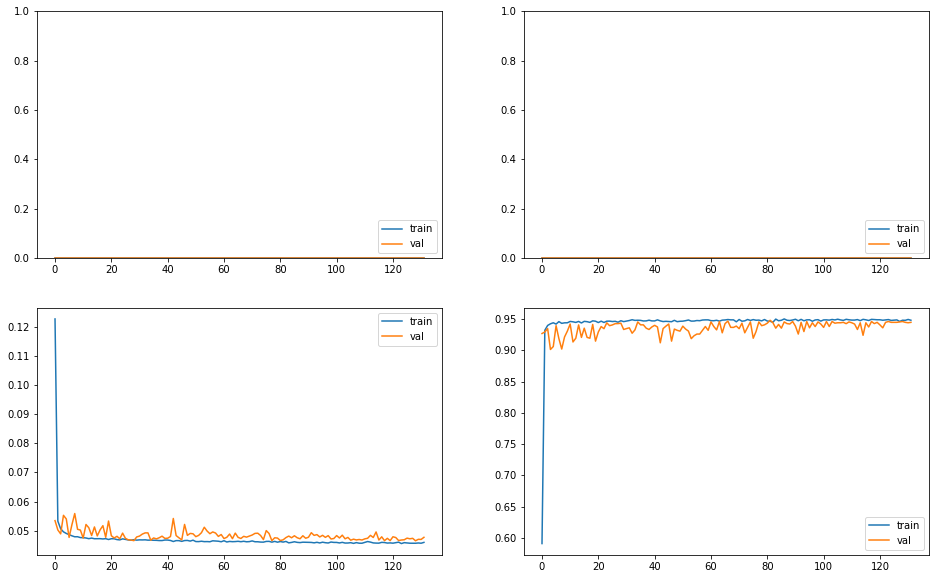

In [21]:
history = hist.history

plt.figure(figsize=(16, 10))
plt.subplot(2, 2, 1)
plt.plot(history['outputs_matthews_correlation_coefficient'], label='train')
plt.plot(history['val_outputs_matthews_correlation_coefficient'], label='val')
plt.ylim(0, 1)
plt.legend(loc='lower right')

plt.subplot(2, 2, 2)
plt.plot(history['outputs_fbeta'], label='train')
plt.plot(history['val_outputs_fbeta'], label='val')
plt.ylim(0, 1)
plt.legend(loc='lower right')

plt.subplot(2, 2, 3)
plt.plot(history['output_eyes_loss'], label='train')
plt.plot(history['val_output_eyes_loss'], label='val')
plt.legend(loc='upper right')

plt.subplot(2, 2, 4)
plt.plot(history['output_eyes_eye_localization_accuracy'], label='train')
plt.plot(history['val_output_eyes_eye_localization_accuracy'], label='val')
plt.legend(loc='lower right')

# Test Model

In [18]:
FILE_MODEL = "../../models/unsupervised_supervised/multilearner_2022_10_12-14_27_09.h5"

custom_objects = {
    "precision": precision,
    "recall": recall,
    "f1": f1,
    "specificity": specificity,
    "fbeta": fbeta,
    "negative_predictive_value": npv,
    "matthews_correlation_coefficient": mcc,
    "eye_localization_fvc": eye_localization_fvc,
    "eye_localization_accuracy": eye_localization_accuracy,
}

model = load_model(FILE_MODEL, custom_objects=custom_objects)

[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
[[1 1 1 0 1 1 1 1 1 0 0 1 1 0 1 1 1 1 1 0 1 1 1]]
[ 59.  83. 100.  82.]
[60.080544 82.33319  98.84749  82.28934 ]


Text(0.5, 1.0, 'decoded image')

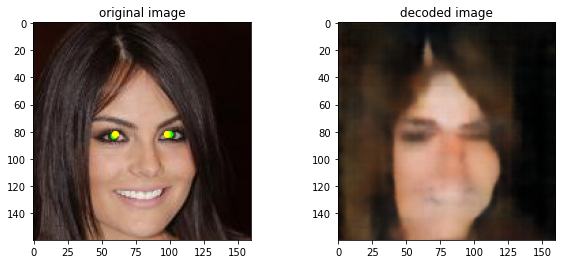

In [24]:
random_idx = np.random.choice(x_val.shape[0])
im = np.expand_dims(x_val[random_idx], axis=0) * 255
y_true_reqs = y_val_reqs[random_idx]
y_true_eyes = y_val_eyes[random_idx] * im.shape[1]
y_pred_decoded, y_pred_reqs, y_pred_eyes = model.predict(im / 255)
y_pred_reqs = np.where(y_pred_reqs > 0.5, 1, 0)
y_pred_eyes = (y_pred_eyes * im.shape[1]).flatten()

print(y_true_reqs, y_pred_reqs, sep='\n')
print(y_true_eyes, y_pred_eyes, sep='\n')

im = (im).squeeze()[:, :, ::-1].astype(np.uint8)
true_r = tuple(y_true_eyes[:2].astype(np.int))
true_l = tuple(y_true_eyes[2:].astype(np.int))
pred_r = tuple(y_pred_eyes[:2].astype(np.int))
pred_l = tuple(y_pred_eyes[2:].astype(np.int))
cv2.circle(im, true_r, radius=1, color=(0, 255, 0), thickness=2)
cv2.circle(im, true_l, radius=1, color=(0, 255, 0), thickness=2)
cv2.circle(im, pred_r, radius=1, color=(255, 255, 0), thickness=2)
cv2.circle(im, pred_l, radius=1, color=(255, 255, 0), thickness=2)

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.imshow(im)
plt.title('original image')

plt.subplot(1, 2, 2)
plt.imshow(y_pred_decoded.squeeze()[:, :, ::-1])
plt.title('decoded image')

# Save Classification Model 

In [25]:
FILE_MODEL_CLF = FILE_MODEL.replace('multilearner', 'model')
print(FILE_MODEL_CLF)

model_clf = Model(
    inputs=model.inputs,
    outputs=[model.get_layer('outputs').output, model.get_layer('output_eyes').output],
    name="ICAOnet"
)
model_clf.summary()

model_clf.save(FILE_MODEL_CLF)

../../models/unsupervised_supervised/model_2022_10_12-14_27_09.h5
Model: "ICAOnet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 160, 160, 3)  0                                            
__________________________________________________________________________________________________
conv_1 (Conv2D)                 (None, 160, 160, 32) 896         input[0][0]                      
__________________________________________________________________________________________________
bn_1 (BatchNormalization)       (None, 160, 160, 32) 128         conv_1[0][0]                     
__________________________________________________________________________________________________
relu_1 (Activation)             (None, 160, 160, 32) 0           bn_1[0][0]                       
__________________________

In [27]:
import cv2
from glob import glob

model_clf = load_model(FILE_MODEL_CLF)

list_files = [PATH_TO_ROOT + 'data/cropped_faces/images/afwDB_0.png']
random_file = np.random.choice(list_files)
print(random_file)

im = load.images_from_list_files([random_file], output_size=IMAGE_SIZE, interpolation=cv2.INTER_AREA)
im /= 255

y_pred_ori = model.predict(im)
y_pred_clf, y_pred_reg = model_clf.predict(im)
assert(np.allclose(y_pred_ori[1], y_pred_clf))
assert(np.allclose(y_pred_ori[2], y_pred_reg))

print("Reqs:")
for y_pred in y_pred_clf[0]:
    print(y_pred)

print("\nEyes:")
for y_pred in y_pred_reg[0]:
    print(y_pred)

../../data/cropped_faces/images/afwDB_0.png
1 of 1
Reqs:
0.64809203
0.9347415
0.99573874
0.08281666
0.991169
0.9998725
0.9772672
0.27883738
0.96358013
0.053408027
0.2058002
0.14253008
0.9828384
0.47127613
0.82925045
0.9903072
0.75461185
0.97962976
0.8930521
0.6584907
0.9751569
0.827954
0.9905076

Eyes:
0.37778363
0.51369214
0.6156575
0.51310587


# Embeddings Visualization 

In [ ]:
FOLDER_LOGS = '../../logs/unsupervised_supervised/'

### Metadata 

In [ ]:
image_files = np.array(dataset.image_files)[x_val_idx]
data = np.array(dataset.images)[x_val_idx]
mrks = np.array(dataset.mrks)[x_val_idx]

image_files = [basename(filepath) for filepath in image_files]
print(len(image_files))
print(data.shape)

In [ ]:
with open(f'{FOLDER_LOGS}/metadata.tsv', 'w') as metadata_file:
    for file in image_files:
        metadata_file.write(file+'\n')

mlflow.log_artifact(f'{FOLDER_LOGS}/metadata.tsv')

### Image Sprite

In [ ]:
def images_to_sprite(data):
    """Creates the sprite image along with any necessary padding
    Args:
      data: NxHxW[x3] tensor containing the images.
    Returns:
      data: Properly shaped HxWx3 image with any necessary padding.
    """
    if len(data.shape) == 3:
        data = np.tile(data[...,np.newaxis], (1,1,1,3))
    data = data.astype(np.float32)
    min_data = np.min(data.reshape((data.shape[0], -1)), axis=1)
    data = (data.transpose(1,2,3,0) - min_data).transpose(3,0,1,2)
    max_data = np.max(data.reshape((data.shape[0], -1)), axis=1)
    data = (data.transpose(1,2,3,0) / max_data).transpose(3,0,1,2)

    n = int(np.ceil(np.sqrt(data.shape[0])))
    padding = ((0, n ** 2 - data.shape[0]), (0, 0), (0, 0)) + ((0, 0),) * (data.ndim - 3)
    data = np.pad(data, padding, mode='constant', constant_values=0)
    
    # Tile the individual thumbnails into an image.
    data = data.reshape((n, n) + data.shape[1:]).transpose((0, 2, 1, 3) + tuple(range(4, data.ndim + 1)))
    data = data.reshape((n * data.shape[1], n * data.shape[3]) + data.shape[4:])
    data = (data * 255).astype(np.uint8)
    return data### Embeddings 

In [ ]:
im_sprite = images_to_sprite(data)
print(im_sprite.shape)

cv2.imwrite(f'{FOLDER_LOGS}/sprites.png', im_sprite)
mlflow.log_artifact(f'{FOLDER_LOGS}/sprites.png')

### Embeddings 

In [ ]:
model = load_model(FILE_MODEL_CLF)

embeddings = GlobalAvgPool2D(name='embeddings')(model.get_layer(name='encoded').output)

model_emb = Model(inputs=model.inputs, outputs=embeddings)
model_emb.summary()

In [ ]:
emb_vectors = model_emb.predict(data)
print(emb_vectors.shape)

### Tensorboard 

In [ ]:
sess = tf.InteractiveSession()

tf_embeddings = tf.Variable(emb_vectors, name='embeddings')
summary_writer = tf.summary.FileWriter(f'{FOLDER_LOGS}')

config = projector.ProjectorConfig()
embedding = config.embeddings.add()
embedding.tensor_name = tf_embeddings.name
embedding.metadata_path = 'metadata.tsv'
embedding.sprite.image_path = 'sprites.png'
embedding.sprite.single_image_dim.extend(IMAGE_SIZE)

projector.visualize_embeddings(summary_writer, config)

saver = tf.train.Saver([tf_embeddings])
sess.run(tf_embeddings.initializer)
saver.save(sess, f'{FOLDER_LOGS}/embeddings.ckpt')

sess.close()

In [ ]:
mlflow.end_run()